# Towards an ICCM paper

This notebook will have two parts. The first will make predictions about reading times (to start, for local coherence effects) from the equations of motion. The second will test the hypothesis that, in the model, the average reading time is monotonically dependent on the relative harmony values of two competing peaks.

To test both of these ideas, we'll use a 2D harmony landscape with two attractors, one at [1, 0] and the other at [0, 1]. The attractor at [1, 0] will be the grammatical parse $\mathbf{x}_g$, and [0, 1] will be the ungrammatical parse $\mathbf{x}_u$.

## Part the first: A line integral approach to predicting reading times

(This is taken largely from [here](http://tutorial.math.lamar.edu/Classes/CalcIII/LineIntegralsPtI.aspx) and Boas (1983, *Mathematical methods in the physical sciences*, Wiley).

The time to travel some distance along a curve $C$ is equal to the distance traveled divided by the speed of travel. Thus, we're looking for an equation of the form $T = dist / speed$. In the general case of $n$-dimensions, this will be a path integral $T = \int_C \mathbf{F}\cdot d\mathbf{r}$, where $\mathbf{F}$ is some vector field and $d\mathbf{r}$ is derivative along the curve $C$, where $C$ has been parameterized using some function $\mathbf{r}(t)$. Ideally, we would define the curve $C$ to be the actual path defined by the dynamics, but that would require an explicit solution to the differential equation $\dot{\mathbf{x}} = \nabla H(\mathbf{x})$, which we don't have. Instead, I'm approximating the actual solution curve with a straight line connecting the initial state $\mathbf{x}_{init}$ and some final state $\mathbf{x}_{fin}$ close to $\mathbf{x}_g$ or $\mathbf{x}_u$.

We want to see how long it takes to get from $\mathbf{x}_{init}$ to $\mathbf{x}_{fin}$, so the force $\mathbf{F}$ from above becomes $\nabla H(\mathbf{x})^{-1}$:
$$
T = \int_C \nabla H(\mathbf{x})^{-1}\cdot d\mathbf{r}
$$
We need to make $H(\cdot)^{-1}$ a function of the 1D position along the curve, so that means writing each element $x_j$ of the state vector $\mathbf{x}$ as function of that position. This position along the curve is given by 
$$
\mathbf{r}(t) = (1 - t)\mathbf{x}_{init} + t\mathbf{x}_{fin}
$$
for $0 \leq t \leq 1$. Note that this parameterization equals $\mathbf{x}_{init}$ at $t = 0$ and $\mathbf{x}_{fin}$ at $t = 1$. With 
$$
d\mathbf{r} = (-\mathbf{x}_0 + \mathbf{x}_1) dt
$$
the integral becomes
$$
T = \int_0^1 \left(\nabla H(\mathbf{r}(t))^{-1}\cdot (-\mathbf{x}_0 + \mathbf{x}_1)\right)dt
$$
which can be evaluated numerically.

In [1]:
# Setting up things in SymPy
from sympy import *
from IPython.display import display

# Declaring scalars
# x0, x1 are the dimensions
x0, x1, h0, h1, gamma, t = symbols('x0 x1 h0 h1 gamma t')  # make these formal symbols for SymPy to manipulate
# x{0, 1}{i, f} are the initial and final positions for the two spatial dimensions
x0i, x1i, x0f, x1f = symbols('x0i x1i x0f x1f')
h0 = 1.0
h1 = 0.5  # For initial testing
gamma = 0.25

# Declaring vectors
x = Matrix([x0, x1])  # state vector
cg = Matrix([1, 0])  # centers of the RBFs
cu = Matrix([0, 1])
xinit = Matrix([x0i, x1i])  # placeholders for now
xfin = Matrix([x0f, x1f])
t1 = Matrix([1-t, 1-t])  # Vectors for calculating r(t)
justt = Matrix([t, t])

H = h0*exp(-(x-cg).dot(x-cg) / gamma) + h1*exp(-(x-cu).dot(x-cu) / gamma)  # defining the harmony function
dxdt = Matrix([diff(H, i) for i in x])
r = xinit.multiply_elementwise(t1) + xfin.multiply_elementwise(justt)
dr = (-xinit + xfin)
display(H, dxdt, r, dr)

0.5*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2) + 1.0*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2)

Matrix([
[-4.0*x0*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2) + 1.0*(-8.0*x0 + 8.0)*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2)],
[-8.0*x1*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2) + 0.5*(-8.0*x1 + 8.0)*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2)]])

Matrix([
[t*x0f + x0i*(-t + 1)],
[t*x1f + x1i*(-t + 1)]])

Matrix([
[x0f - x0i],
[x1f - x1i]])

In [2]:
# Calculating the locations of the fixed points
xg = nsolve(dxdt, x, (1, 0))
xu = nsolve(dxdt, x, (0, 1))
xmid = nsolve(dxdt, x, (0.5, 0.5))
print('x_g = {}\nx_u = {}\nsaddle = {}'.format(xg, xu, xmid))

x_g = Matrix([[0.999831845081734], [0.000168154918266462]])
x_u = Matrix([[0.000677780997818818], [0.999322219002181]])
saddle = Matrix([[0.442150996291071], [0.557849003708929]])


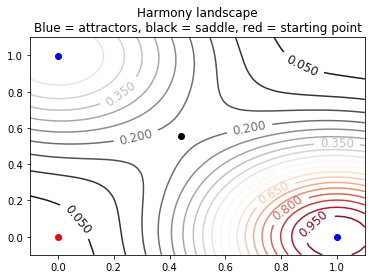

In [4]:
# Plotting the harmony landscape and fixed points
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

Hnum = lambdify(x, H)  # Making a numerical version of the symbolic function
delta = 0.025  # Grid size for calculating the harmony
xx1 = np.arange(-0.1, 1.1, delta)
xx2 = np.arange(-0.1, 1.1, delta)
Z = np.zeros((len(xx1), len(xx2)))  # Harmony
for i, j in product(range(len(xx1)), range(len(xx2))):
    Z[i, j] = Hnum(xx1[i], xx2[j])


# Making the contour plot
clines = plt.contour(xx1, xx2, Z.T, 20, cmap='RdGy_r')
plt.clabel(clines, clines.levels[::3], inline=True, fontsize=12)
# Marking the fixed pts.
plt.plot(xg[0], xg[1], marker='o', color='blue')
plt.plot(xu[0], xu[1], marker='o', color='blue')
plt.plot(xmid[0], xmid[1], marker='o', color='k')
plt.plot(0, 0, marker='o', color='red')  # init. condition
plt.title('Harmony landscape\nBlue = attractors, black = saddle, red = starting point')
plt.show()

In [6]:
# Now we can calculate the integral shown above
# Takes a few seconds...
integrand = Matrix(np.reciprocal(dxdt.subs({x0: r[0], x1: r[1]})))
integrand.dot(dr)  # 
integrand_g = (integrand.dot(dr)).subs({x0i: 0, x1i: 0, x0f: xg[0]-0.1, x1f: xg[1]-0.1})
Tg = Integral(integrand_g, (t, 0, 1)).evalf()
integrand_u = (integrand.dot(dr)).subs({x0i: 0, x1i: 0, x0f: xu[0]-0.1, x1f: xu[1]-0.1})
Tu = Integral(integrand_u, (t, 0, 1)).evalf()
print('Time to grammatical = {}\nTime to ungrammatical = {}'.format(Tg, Tu))

Time to grammatical = 0.618841121217809
Time to ungrammatical = 2.24774354722145


In [8]:
# Changing the harmony height of the ungrammatical parse:
integrand_u = (integrand.dot(dr)).subs({h1: 0.25, x0i: 0, x1i: 0, x0f: xu[0]-0.1, x1f: xu[1]-0.1})
Tu2 = Integral(integrand_u, (t, 0, 1)).evalf()
print('Time to ungrammatical (h1 = 0.25) = {}'.format(Tu2))

Time to ungrammatical (h1 = 0.25) = 5.58320971411626


### Summing up so far

So, it looks like the line integral approach is making coherent predictions about settling times to different attractors: Higher-harmony attractors are approached faster than lower-harmony ones.

The overall theory of reading times here is that the overall average time is the weighted average of how long it takes to settle to each attractor weighted by how often the system goes to that attractor. We now have predictions about how fast it takes to get to each attractor, now we want to look at how often it goes to each one.

## Part the second: Relative harmony heights and reading times

Here's the plan for this part: Start with the two harmony peaks at the same height $h_0 = h_1 = 1.0$. Do 1000 runs with $\mathbf{x}_{init} = [0, 0]^\intercal$, $h_0 = 1.0$, and $\gamma = 0.25$, recording which attractor is chosen and how long it takes. This first case is to make sure things are working correctly.

After that, I'll gradually lower $h_1$ in increments of $\Delta h = 0.1$. The hope is that the mean RT for all 1000 runs will decrease as $h_1 \rightarrow 0.0$. The lower harmony of $\mathbf{x}_1$ should, on the one hand, make approaches to it much slower, on the other hand, $\mathbf{x}_0$ will be chosen more often, so the average RT should go down.

In [70]:
# Running the Monte-Carlo simulations
import pandas as pd

centers = np.array([[1, 0], [0, 1]])
harmonies = np.array([1.0, 1.])
gamma = 0.25
ndim = centers.shape[1]
D = 0.001  # Small noise
maxsteps = 1000
tau = 0.01
xinit = np.array([0, 0.])  # starting at the midpoint between the two attractors


# Defining functions
def phi(x, center, gamma):
    """RBF centers"""
    l2norm = np.linalg.norm(x - center)
    return np.exp(-l2norm**2 / gamma)


def calc_harmony(x, centers, harmonies, gamma):
    """Calculate the harmony at a given position"""
    harmony = 0
    for c in range(centers.shape[0]):
        harmony += harmonies[c] * phi(x, centers[c], gamma)
    return harmony


def step_dyn(x, centers, harmonies, gamma):
    """Iterate the discretized dynamics"""
    dx = np.zeros(x.shape)
    mult = -2./gamma
    for c in range(centers.shape[0]):
        dx += (mult * harmonies[c]
               * (x - centers[c]) * phi(x, centers[c], gamma))
    return dx


def not_close(x, centers, tol):
    """Returns True if not close to one of the centers"""
    l2norm = np.zeros(centers.shape[0])
    for c in range(centers.shape[0]):
        diff = x - centers[c]
        l2norm[c] = np.sqrt(np.dot(diff, diff))
    if np.any(l2norm < tol):
        return False
    else:
        return True

# Running
xhist = np.zeros((maxsteps, ndim))
nruns = 2000
data_list = []
hvals = np.arange(1.0, 0.0, -0.05)

for h in range(len(hvals)):
    harmonies[1] = hvals[h]
    print('\nh_1 = {}'.format(hvals[h]))
    for run in range(nruns):
        if run % 100 == 0:
            print('[{}] '.format(run), end='')
        xhist[0,] = xinit
        noise = np.random.normal(0, 1, xhist.shape)
        t = 0
        while t < maxsteps-1:
            if not_close(xhist[t], centers, 0.1):
                xhist[t+1,] = (xhist[t,] + tau*step_dyn(xhist[t,], centers, harmonies, gamma)
                              + np.sqrt(2*D*tau)*noise[t,])
                t += 1
            else:
                break
        if np.all(np.round(xhist[t,]) == centers[0,]):
            data_list.append([hvals[h], 'A', t])
        elif np.all(np.round(xhist[t,]) == centers[1,]):
            data_list.append([hvals[h], 'B', t])
        else:
            data_list.append([hvals[h], 'Other', t])

    if nruns == 1:
        plt.plot(xhist)
        plt.show()

data = pd.concat([pd.DataFrame([i], columns=('Harmony1', 'Attractor', 'Time')) for i in data_list])


h_1 = 1.0
[0] [100] [200] [300] [400] [500] [600] [700] [800] [900] [1000] [1100] [1200] [1300] [1400] [1500] [1600] [1700] [1800] [1900] 
h_1 = 0.95
[0] [100] [200] [300] [400] [500] [600] [700] [800] [900] [1000] [1100] [1200] [1300] [1400] [1500] [1600] [1700] [1800] [1900] 
h_1 = 0.8999999999999999
[0] [100] [200] [300] [400] [500] [600] [700] [800] [900] [1000] [1100] [1200] [1300] [1400] [1500] [1600] [1700] [1800] [1900] 
h_1 = 0.8499999999999999
[0] [100] [200] [300] [400] [500] [600] [700] [800] [900] [1000] [1100] [1200] [1300] [1400] [1500] [1600] [1700] [1800] [1900] 
h_1 = 0.7999999999999998
[0] [100] [200] [300] [400] [500] [600] [700] [800] [900] [1000] [1100] [1200] [1300] [1400] [1500] [1600] [1700] [1800] [1900] 
h_1 = 0.7499999999999998
[0] [100] [200] [300] [400] [500] [600] [700] [800] [900] [1000] [1100] [1200] [1300] [1400] [1500] [1600] [1700] [1800] [1900] 
h_1 = 0.6999999999999997
[0] [100] [200] [300] [400] [500] [600] [700] [800] [900] [1000] [1100] [1200] 

In [71]:
# Checking to make sure it saved alright
print(data.head())
print(data.tail())

   Harmony1 Attractor  Time
0       1.0         B   155
0       1.0         A   127
0       1.0         B   160
0       1.0         B   157
0       1.0         B   175
   Harmony1 Attractor  Time
0      0.05         A   215
0      0.05         A   126
0      0.05         A   140
0      0.05         A   145
0      0.05         A   161


In [72]:
# Basic descriptive statistics
data.groupby('Harmony1').describe()

Time                                                          
           count      mean        std    min     25%    50%     75%    max
Harmony1                                                                  
0.05      2000.0  144.2365  21.028853   95.0  130.00  141.0  156.00  360.0
0.10      2000.0  143.5670  19.916698  100.0  130.00  141.0  155.00  244.0
0.15      2000.0  143.9000  20.203294  100.0  130.00  141.0  155.00  280.0
0.20      2000.0  145.2540  20.683820  103.0  131.00  143.0  156.00  265.0
0.25      2000.0  144.4340  20.468515   98.0  130.00  142.0  155.00  260.0
0.30      2000.0  145.3810  21.858516  100.0  130.00  142.0  156.00  271.0
0.35      2000.0  146.0240  21.115287  103.0  131.00  143.0  157.00  288.0
0.40      2000.0  147.2205  21.925630  104.0  132.00  144.0  158.00  294.0
0.45      2000.0  148.6180  23.521984   96.0  133.00  145.0  160.00  337.0
0.50      2000.0  150.2350  25.759902  100.0  133.00  146.0  162.00  329.0
0.55      2000.0  151.7645  25.591024  102.0  134.00  147.0  164.00  339.0
0.60      2000.0  153.2485  27.227200  104.0  135.00  148.0  165.00  361.0
0.65      2000.0  155.2095  28.482912  103.0  135.75  149.0  168.00  298.0
0.70      2000.0  157.0840  29.073451   99.0  137.00  151.0  170.00  336.0
0.75      2000.0  158.2775  28.366456  103.0  138.00  153.0  172.00  300.0
0.80      2000.0  159.1890  28.404783  100.0  138.00  155.0  176.00  286.0
0.85      2000.0  159.4985  27.003770  105.0  140.00  156.0  174.25  325.0
0.90      2000.0  158.3335  25.497183  103.0  140.00  155.0  173.00  339.0
0.95      2000.0  156.6310  24.050552   98.0  139.00  153.0  170.00  312.0
1.00      2000.0  152.9830  23.355287  101.0  137.00  149.0  166.00  286.0

In [76]:
data.groupby(['Attractor', 'Harmony1']).describe()  # basic info by attractor

Time                                               \
                     count        mean        std    min     25%    50%   
Attractor Harmony1                                                        
A         0.05      2000.0  144.236500  21.028853   95.0  130.00  141.0   
          0.10      2000.0  143.567000  19.916698  100.0  130.00  141.0   
          0.15      2000.0  143.900000  20.203294  100.0  130.00  141.0   
          0.20      2000.0  145.254000  20.683820  103.0  131.00  143.0   
          0.25      2000.0  144.434000  20.468515   98.0  130.00  142.0   
          0.30      2000.0  145.381000  21.858516  100.0  130.00  142.0   
          0.35      2000.0  146.024000  21.115287  103.0  131.00  143.0   
          0.40      1999.0  147.147074  21.683763  104.0  132.00  144.0   
          0.45      1995.0  148.295739  22.527833   96.0  133.00  145.0   
          0.50      1984.0  149.303931  23.495815  100.0  133.00  146.0   
          0.55      1975.0  150.634937  23.417381  102.0  134.00  147.0   
          0.60      1952.0  151.543033  24.723011  104.0  135.00  147.0   
          0.65      1920.0  152.677083  25.394334  103.0  135.00  148.0   
          0.70      1848.0  152.984848  24.447479   99.0  136.00  149.0   
          0.75      1764.0  153.566893  24.958447  103.0  136.00  150.0   
          0.80      1639.0  153.824893  25.759771  100.0  135.00  150.0   
          0.85      1479.0  153.661258  24.899817  105.0  136.00  150.0   
          0.90      1324.0  153.409366  25.005035  103.0  136.00  150.0   
          0.95      1177.0  154.396771  24.328808   98.0  136.00  151.0   
          1.00       954.0  152.041929  22.998570  101.0  136.00  148.0   
B         0.40         1.0  294.000000        NaN  294.0  294.00  294.0   
          0.45         5.0  277.200000  52.864922  213.0  242.00  270.0   
          0.50        16.0  265.687500  33.437940  218.0  244.75  266.5   
          0.55        25.0  241.000000  32.314857  187.0  219.00  238.0   
          0.60        48.0  222.604167  33.525944  171.0  204.75  218.0   
          0.65        80.0  215.987500  31.098249  160.0  192.50  214.5   
          0.70       152.0  206.921053  34.255860  135.0  182.75  201.0   
          0.75       236.0  193.487288  27.566011  140.0  174.00  190.0   
          0.80       361.0  183.542936  27.114038  126.0  165.00  180.0   
          0.85       521.0  176.069098  25.864421  119.0  158.00  172.0   
          0.90       676.0  167.977811  23.644737  106.0  151.75  165.0   
          0.95       823.0  159.826245  23.291712  110.0  143.00  156.0   
          1.00      1046.0  153.841300  23.654281  105.0  138.00  150.0   

                                   
                       75%    max  
Attractor Harmony1                 
A         0.05      156.00  360.0  
          0.10      155.00  244.0  
          0.15      155.00  280.0  
          0.20      156.00  265.0  
          0.25      155.00  260.0  
          0.30      156.00  271.0  
          0.35      157.00  288.0  
          0.40      158.00  254.0  
          0.45      160.00  266.0  
          0.50      161.00  329.0  
          0.55      163.00  270.0  
          0.60      163.00  305.0  
          0.65      165.00  292.0  
          0.70      165.00  282.0  
          0.75      166.00  298.0  
          0.80      167.00  280.0  
          0.85      167.00  325.0  
          0.90      167.00  339.0  
          0.95      168.00  312.0  
          1.00      164.00  286.0  
B         0.40      294.00  294.0  
          0.45      324.00  337.0  
          0.50      278.75  329.0  
          0.55      256.00  339.0  
          0.60      233.25  361.0  
          0.65      232.00  298.0  
          0.70      227.25  336.0  
          0.75      210.00  300.0  
          0.80      199.00  286.0  
          0.85      192.00  260.0  
          0.90      182.25  261.0  
          0.95      172.00  275.0  
          1.00      168.00  279.0

In [122]:
# Calculating descriptive statistics
byharmony = data.groupby(['Harmony1', 'Attractor']).agg('count')
props = byharmony.groupby(level=0).apply(lambda x: x / x.sum())
propa = props.xs('A', level=1)  # Proportions of A-parses by h1 harmony

means = data.groupby('Harmony1').describe().iloc[:, 1]  # Mean settling times

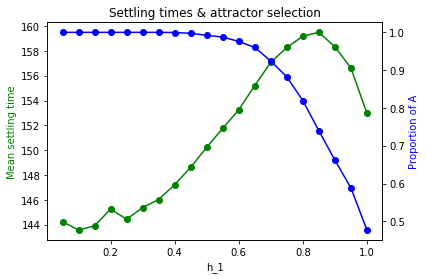

In [121]:
# Making a figure of mean settling time and proportion of A attractors
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(hvals[::-1], means, 'g-o')
ax2.plot(hvals[::-1], propa, 'b-o')

ax1.set_xlabel('h_1')
ax1.set_ylabel('Mean settling time', color='g')
ax2.set_ylabel('Proportion of A', color='b')
plt.title('Settling times & attractor selection')
plt.show()

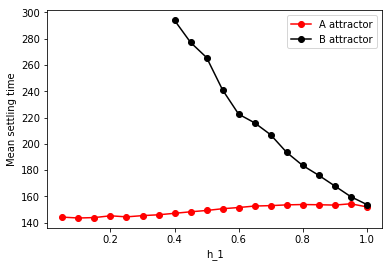

In [145]:
# Looking at the settling times by attractor chosen and h1
rts = data.groupby(['Attractor', 'Harmony1']).describe().iloc[:, 1]
#print(rts.xs('B'))
plt.plot(hvals[::-1], rts.xs('A'), 'r-o', label='A attractor')
plt.plot(hvals[0:13,][::-1], rts.xs('B'), 'k-o', label='B attractor')
plt.ylabel('Mean settling time')
plt.xlabel('h_1')
plt.legend()
plt.show()
